# scSpatial Seurat

In [1]:
# install.packages("Seurat")

In [2]:
# Library import

library(Seurat)
library(ggplot2)
library(patchwork)
library(dplyr)
library(magrittr)

set.seed(1)

# Multicore CPU usage activation - Future
library(future)

plan("multicore", workers = 10) 
# Set RAM Size to 3/4 of total RAM
options(future.globals.maxSize = 16000 * 1024^2)

future.seed=TRUE # Removes future-generated statistical errors

Warning message:
“пакет ‘Seurat’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: SeuratObject

Warning message:
“пакет ‘SeuratObject’ был собран под R версии 4.3.3”
Загрузка требуемого пакета: sp


Присоединяю пакет: ‘SeuratObject’


Следующие объекты скрыты от ‘package:base’:

    intersect, t


Warning message:
“пакет ‘patchwork’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘dplyr’


Следующие объекты скрыты от ‘package:stats’:

    filter, lag


Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“пакет ‘future’ был собран под R версии 4.3.3”


In [3]:
library(data.table)
# Load data
cell_by_gene <- fread("cell_by_gene.csv", data.table = FALSE)
cell_metadata <- fread("cell_metadata.csv", data.table = FALSE)

# Extract cell barcodes and gene names
cell_barcodes <- cell_by_gene[, 1]  # First column contains cell barcodes
gene_names <- colnames(cell_by_gene)[-1]  # Gene names are column names

# Ensure unique gene names
gene_names <- make.unique(gene_names)  

# Transpose matrix
cell_by_gene <- t(cell_by_gene[, -1])  # Remove first column (cell barcodes) before transposing

# Assign correct row & col names
rownames(cell_by_gene) <- gene_names  # Genes as row names
colnames(cell_by_gene) <- make.unique(cell_barcodes)  # Ensure unique cell names

# Convert to matrix
cell_by_gene <- as.matrix(cell_by_gene)

# Create Seurat object
Seurat <- CreateSeuratObject(counts = cell_by_gene)

# Fix metadata cell names
cell_metadata$V1 <- gsub("_\\d+$", "", cell_metadata$V1)  # Remove suffixes like "_10" if needed
rownames(cell_metadata) <- make.unique(cell_metadata$V1)  # Ensure unique rownames

# Remove first column from metadata
cell_metadata <- cell_metadata[, -1]

# Check if names match
print(all(rownames(cell_metadata) %in% colnames(Seurat)))  # Should return TRUE

# Add metadata
Seurat <- AddMetaData(Seurat, metadata = cell_metadata)

Seurat

Warning message:
“пакет ‘data.table’ был собран под R версии 4.3.3”

Присоединяю пакет: ‘data.table’


Следующие объекты скрыты от ‘package:dplyr’:

    between, first, last


Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”


[1] FALSE


An object of class Seurat 
2711 features across 27236 samples within 1 assay 
Active assay: RNA (2711 features, 0 variable features)
 1 layer present: counts

In [4]:
head(Seurat@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,center_x,center_y,z,fov
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>
AACAGGAAGAGCATAG-1_9_1,SeuratProject,2,2,2052.840,337.2055,0,0
AACAGGAAGAGCATAG-1_9_2,SeuratProject,2,2,2070.469,328.8508,0,0
AACAGGAAGAGCATAG-1_9_3,SeuratProject,2,2,2057.671,328.5484,0,0
AACAGGATTCATAGTT-1_13_1,SeuratProject,11,11,1684.970,708.5529,0,0
AACAGGATTCATAGTT-1_13_2,SeuratProject,11,11,1689.184,718.4961,0,0
AACAGGATTCATAGTT-1_13_3,SeuratProject,11,11,1683.524,713.4949,0,0


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


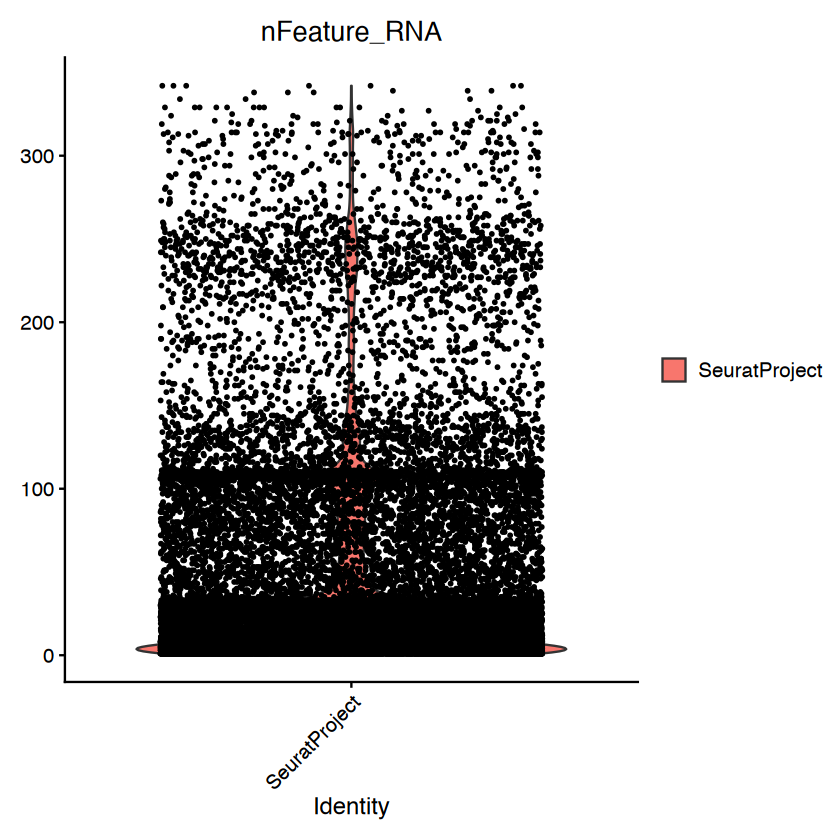

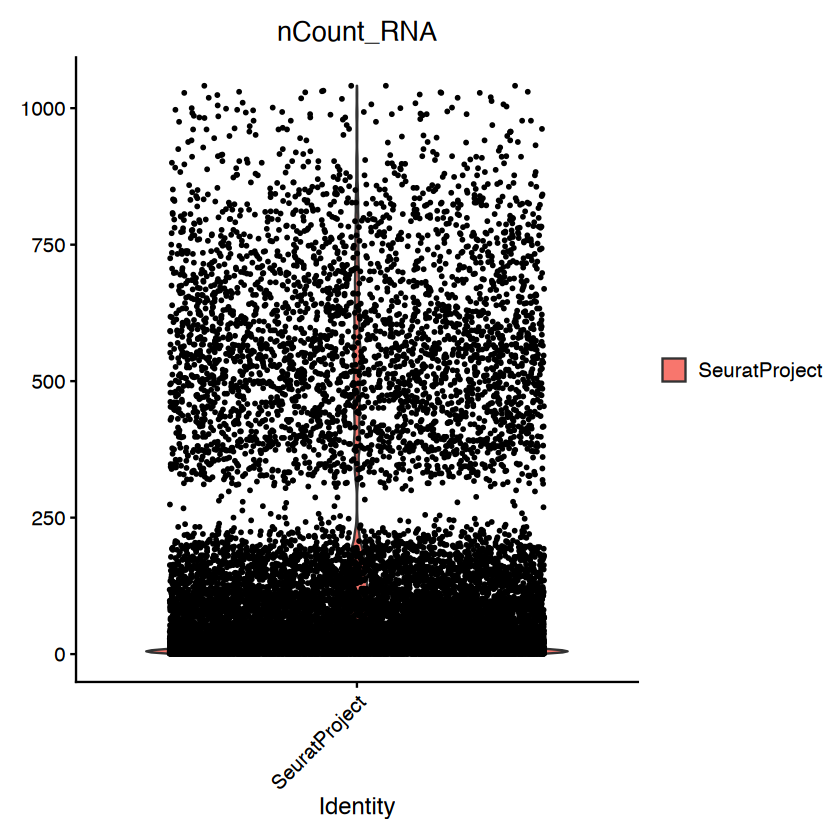

In [5]:
VlnPlot(Seurat, features = "nFeature_RNA")
VlnPlot(Seurat, features = "nCount_RNA")

In [6]:
distance_clusters <- read.csv("cluster_info.csv")
Seurat <- AddMetaData(Seurat, metadata = distance_clusters$Cluster, col.name = "CellType")
Seurat <- SetIdent(Seurat, value = "CellType")

Seurat

An object of class Seurat 
2711 features across 27236 samples within 1 assay 
Active assay: RNA (2711 features, 0 variable features)
 1 layer present: counts

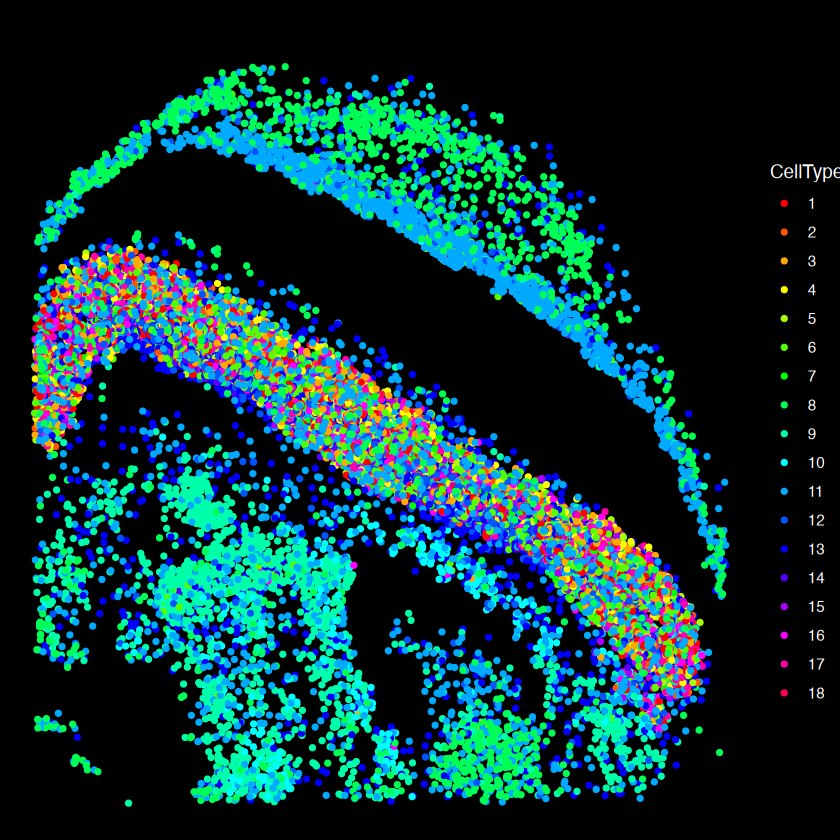

In [7]:
Seurat@meta.data$center_x <- as.numeric(Seurat@meta.data$center_x)
Seurat@meta.data$center_y <- as.numeric(Seurat@meta.data$center_y)

# Plot clusters with black background
ggplot(Seurat@meta.data, aes(x = center_x, y = center_y, color = as.factor(CellType))) +
  geom_point(size = 1) +
  scale_color_manual(values = rainbow(length(unique(Seurat$CellType)))) + # Custom colors
  theme_void() +  # Remove axis
  theme(panel.background = element_rect(fill = "black", color = "black"), 
        plot.background = element_rect(fill = "black"),
        legend.text = element_text(color = "white"),
        legend.title = element_text(color = "white")) +
  labs(title = "Spatial Plot of Clusters", color = "CellType")

ggsave(
  "Spatial Cluster Plot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 42,
  height = 40,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

In [8]:
levels(Seurat) <- c('1','2','3','4','5','6','7','8','9','10',
                    '11','12','13','14','15','16','17','18')

new.cluster.ids <- c('1','2','3','4','5','6','7','8','9','10',
                     '11','12','13','14','15','16','17','18')

names(new.cluster.ids) <- levels(Seurat)

Seurat <- RenameIdents(Seurat, new.cluster.ids)

Загрузка требуемого пакета: viridisLite

Warning message:
“No layers found matching search pattern provided”
Warning message in FetchData.Assay5(object = object[[DefaultAssay(object = object)]], :
“data layer is not found and counts layer is used”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


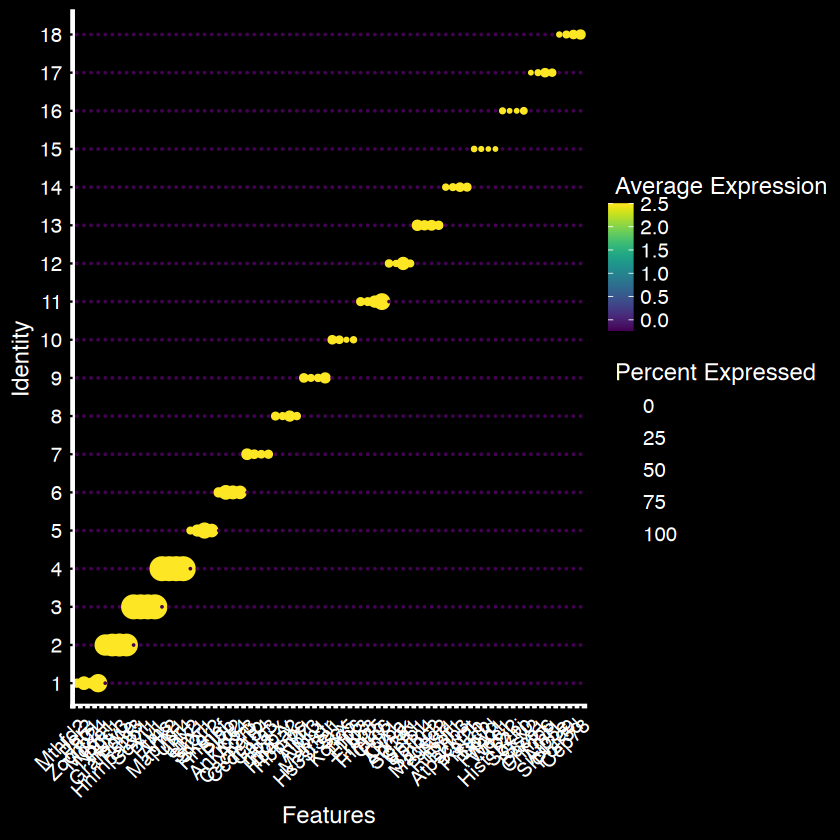

In [9]:
cluster_features = c('Mthfd2', 'Ier2', 'Pag1', 'Zcchc24',
                     'Mdga1', 'Npdc1', 'Rufy3', 'Gramd1a',
                     'Pdia3', 'Hnrnpa2b1', 'Sox11', 'Yy1',
                     'Ptms', 'Ank2', 'Map7d1', 'Ubr4',
                     'Lhx2', 'Lhx1', 'Skor1', 'Skor2',
                     'Hnrnpf', 'Slbp', 'Pkd2', 'Ankrd54',
                     'Actr3', 'Cacna1b', 'Ccdc184', 'Gata3',
                     'Hba-x','Hbb-y','Hba-a2','Hbb-bs', 
                     'Ryr1', 'Alpk3', 'Jph1', 'Mamstr',
                     'Hs3st3a1', 'Scx', 'Kcnq5', 'Trip6',
                     'Tjp3', 'Erbb3', 'Trim25', 'Clic6',
                     'Fdx1', 'Cyba', 'Ahnak', 'Slc2a1',
                     'Sntb1', 'Vstm4', 'Smoc2', 'Maged2',
                     'Nsl1', 'Rhbdf1', 'Efnb3', 'Atpsckmt',
                     'Kat2b', 'Prkacb', 'Dpyd', 'Pithd1',
                     'Wee1', 'Tbx2', 'Hist1h2bj', 'Sox10',
                     'Gsx2', 'Bace1', 'Chmp6', 'Lmf1',
                     'Atp5e', 'Slc12a9', 'Polr3d', 'Cep78')

library(viridis)
DotPlot(Seurat, features = cluster_features) + RotatedAxis() + scale_colour_viridis() +DarkTheme()

# Save the last plot as a pdf

ggsave(
  "Dot plot.pdf",
  plot = last_plot(),
  device = "pdf",
#   path = NULL,
#   scale = 1,
#   1 plot == 10 cm in each dimention
  width = 54,
  height = 20,
  units = "cm",
  dpi = 10000,
  limitsize = TRUE,
#   bg = NULL,
)

# Tip! Open PDF files in Pixelmator Pro and export them as 1x jpg for papers!